In [35]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import MolToSmiles
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from rdkit.Chem import AllChem
import umap

In [3]:
df= pd.read_csv('../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025-sequence.csv')  # data after curation
print(len(df))

3200


In [51]:
# Assume df is your DataFrame
columns_to_check = ['Target', 'E3 Ligase', 'DC50 (nM)', 'Dmax (%)', 'Cell Type']

# Create a dictionary to store the number of non-null values for each column
non_null_counts = {column: df[column].notnull().sum() for column in columns_to_check}

# Print the results
for column, count in non_null_counts.items():
    print(f"Column '{column}' has {count} non-null entries.")

Column 'Target' has 2275 non-null entries.
Column 'E3 Ligase' has 3200 non-null entries.
Column 'DC50 (nM)' has 2376 non-null entries.
Column 'Dmax (%)' has 1527 non-null entries.
Column 'Cell Type' has 3012 non-null entries.


### Comparision between PROTAC-DB 3.0 vs. PROTAC-Pedia

In [ ]:
# Load DataFrames
df2 = pd.read_csv('../PROTAC-Degradation-Predictor/data/2-24-PROTAC-DB.csv')  # raw data- PROTAC-DB 3.0
df1 = pd.read_csv('../PROTAC-Degradation-Predictor/data/PROTAC-Pedia.csv')   # raw data- PROTAC-Pedia

# Ensure the columns exist
if 'PROTAC SMILES' in df1.columns and 'Smiles' in df2.columns:
    # Canonicalize the SMILES
    smiles_set1 = set(df1['PROTAC SMILES'].dropna().apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), canonical=True)))
    smiles_set2 = set(df2['Smiles'].dropna().apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), canonical=True)))

    # Find the common canonical SMILES
    common_smiles = smiles_set1.intersection(smiles_set2)

    # Output the number of common canonical smiles
    print(f"Number of common canonical SMILES: {len(common_smiles)}")
else:
    print("One of the columns does not exist in the DataFrames.")

Number of common canonical SMILES: 808


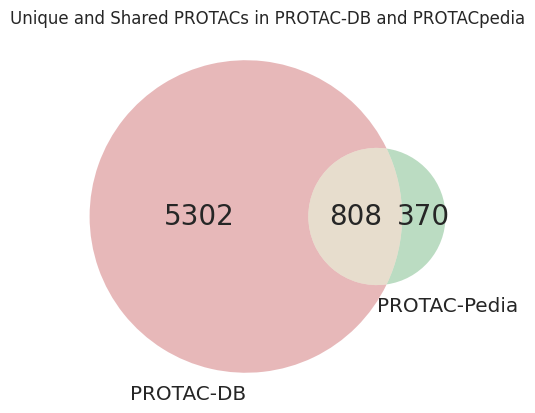

In [13]:
# Function to standardize SMILES
def standardize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Use canonical SMILES to ensure uniqueness
            return MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None

# Example SMILES datasets

dmax_smiles = df2['Smiles']
dc50_smiles = df1['PROTAC SMILES']

# Standardize SMILES
dmax_set = set(filter(None, map(standardize_smiles, dmax_smiles)))
dc50_set = set(filter(None, map(standardize_smiles, dc50_smiles)))

# Draw the Venn diagram
venn = venn2([dmax_set, dc50_set], ('PROTAC-DB', 'PROTAC-Pedia'))
plt.title('Unique and Shared PROTACs in PROTAC-DB and PROTACpedia')
for subset_label in venn.subset_labels:
    if subset_label:  # Avoid errors caused by empty labels
        subset_label.set_fontsize(20)
# Show the plot
plt.show()

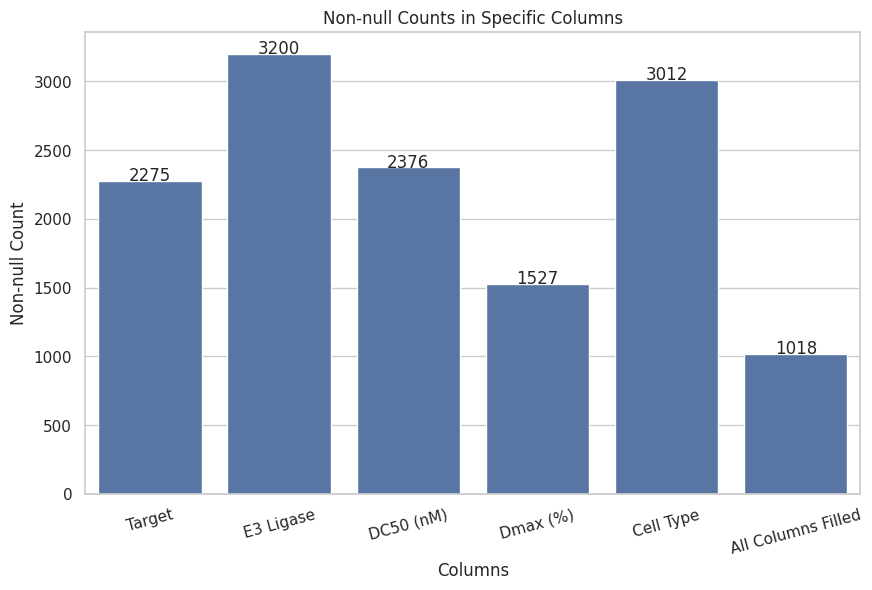

In [52]:
# Assume df is your DataFrame
columns_to_check = ['Target', 'E3 Ligase', 'DC50 (nM)', 'Dmax (%)', 'Cell Type']

# Calculate the number of non-null values in each column
non_null_counts = {column: df[column].notnull().sum() for column in columns_to_check}

# Calculate the number of rows where all specified columns have values
fully_filled_count = df.dropna(subset=columns_to_check).shape[0]

# Add 'All Columns Filled' to the dictionary for visualization purposes
non_null_counts['All Columns Filled'] = fully_filled_count

# Create a visualization that includes information from all columns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the bar chart
sns.barplot(x=list(non_null_counts.keys()), y=list(non_null_counts.values()))
plt.title("Non-null Counts in Specific Columns")
plt.ylabel("Non-null Count")
plt.xlabel("Columns")

# Display the non-null count above each bar
for index, value in enumerate(non_null_counts.values()):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.xticks(rotation=15)  # Rotate labels if needed
plt.show()

### Comparision between PROTAC-DB 3.0 vs. 2.0

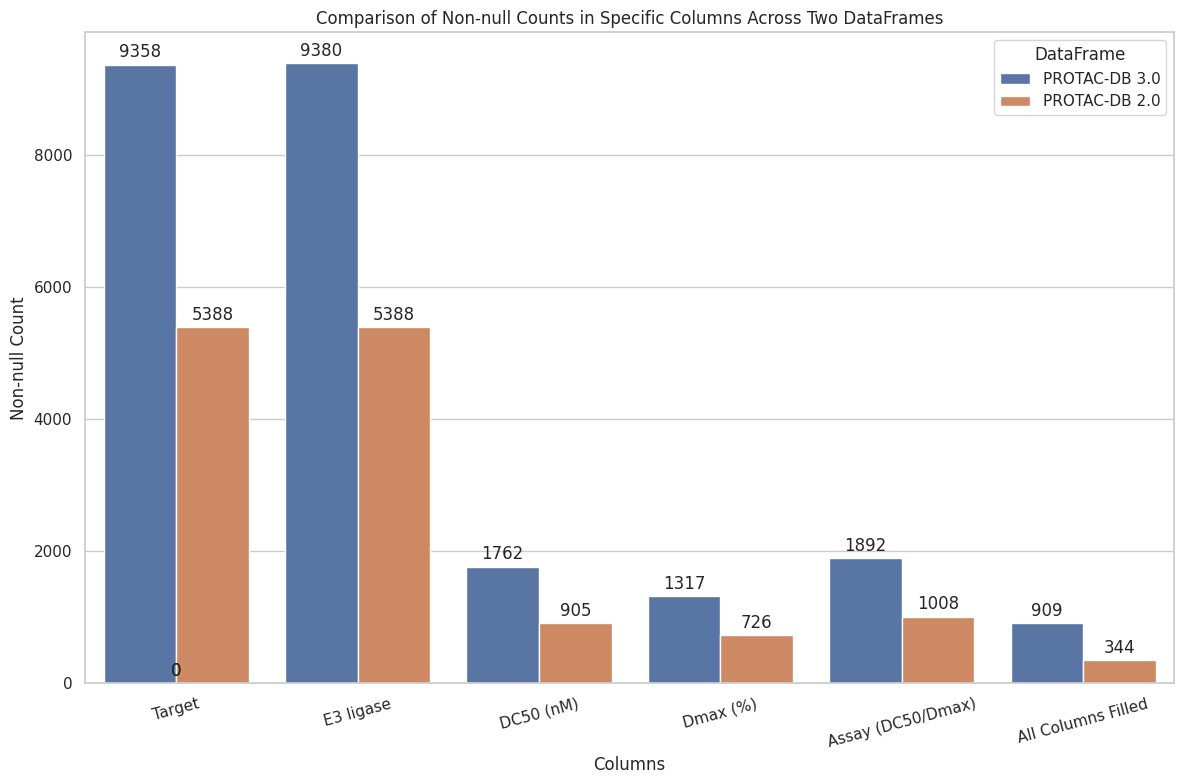

In [15]:
df1 = pd.read_csv('../data/2-24-PROTAC-DB.csv') # raw PROTAC-3.0
df2 = pd.read_csv('../data/PROTAC-DB.csv') # raw PROTAC-2.0
# Define the columns to check
columns_to_check = ['Target', 'E3 ligase', 'DC50 (nM)', 'Dmax (%)', 'Assay (DC50/Dmax)']

# Calculate non-null counts for each DataFrame
non_null_counts_df1 = {column: df1[column].notnull().sum() for column in columns_to_check if column in df1.columns}
non_null_counts_df2 = {column: df2[column].notnull().sum() for column in columns_to_check if column in df2.columns}

# Calculate all columns filled count
fully_filled_count_df1 = df1.dropna(subset=[col for col in columns_to_check if col in df1.columns]).shape[0]
fully_filled_count_df2 = df2.dropna(subset=[col for col in columns_to_check if col in df2.columns]).shape[0]

# Add 'All Columns Filled' for both DataFrames
non_null_counts_df1['All Columns Filled'] = fully_filled_count_df1
non_null_counts_df2['All Columns Filled'] = fully_filled_count_df2

# Create a DataFrame for plotting comparison
plot_df = pd.DataFrame({
    'Columns': list(non_null_counts_df1.keys()),
    'PROTAC-DB 3.0': list(non_null_counts_df1.values()),
    'PROTAC-DB 2.0': list(non_null_counts_df2.values())
})

# Melt the DataFrame for Seaborn
melted_plot_df = plot_df.melt(id_vars='Columns', var_name='DataFrame', value_name='Non-null Count')

# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot using seaborn
ax = sns.barplot(x='Columns', y='Non-null Count', hue='DataFrame', data=melted_plot_df)

plt.title("Comparison of Non-null Counts in Specific Columns Across Two DataFrames")
plt.ylabel("Non-null Count")
plt.xlabel("Columns")
plt.xticks(rotation=15)  # Rotate the labels if needed
plt.legend(title='DataFrame')

# Annotate each bar in the barplot with the numerical values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

1762 1762


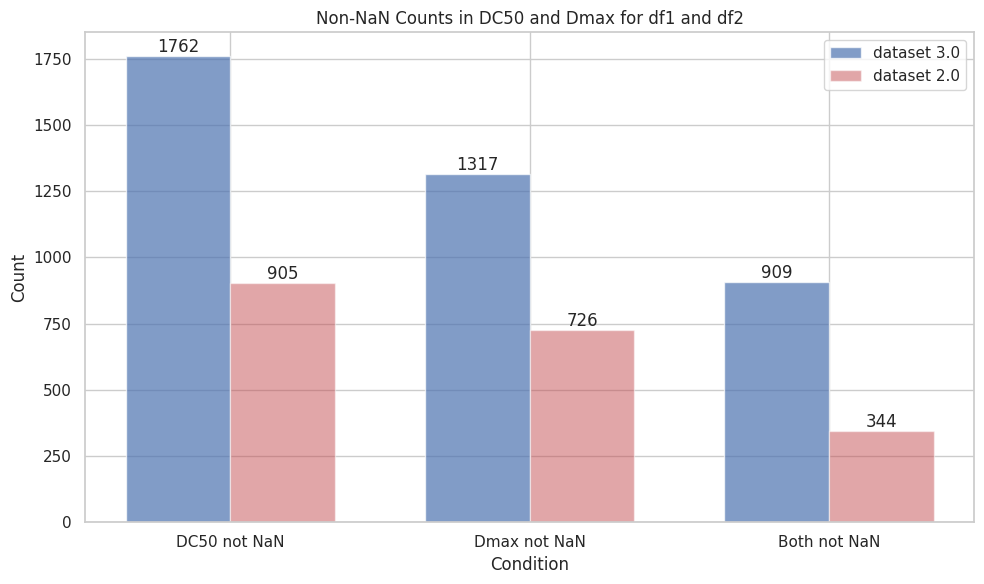

In [19]:
dc50_not_nan_df1 = df1['DC50 (nM)'].notna().sum()
num_dc50_notna = len(df1.dropna(subset=['DC50 (nM)']).dropna(how='all').drop_duplicates())
dc50_not_nan_df2 = df2['DC50 (nM)'].notna().sum()
print(num_dc50_notna, dc50_not_nan_df1)

dmax_not_nan_df1 = df1['Dmax (%)'].notna().sum()
dmax_not_nan_df2 = df2['Dmax (%)'].notna().sum()

both_not_nan_df1 = df1.dropna(subset=['DC50 (nM)', 'Dmax (%)']).shape[0]
both_not_nan_df2 = df2.dropna(subset=['DC50 (nM)', 'Dmax (%)']).shape[0]

# Names and counts for each condition
labels = ['DC50 not NaN', 'Dmax not NaN', 'Both not NaN']
counts_df1 = [dc50_not_nan_df1, dmax_not_nan_df1, both_not_nan_df1]
counts_df2 = [dc50_not_nan_df2, dmax_not_nan_df2, both_not_nan_df2]

x = range(len(labels))  # Positions for the x-axis ticks
bar_width = 0.35  # Width of each bar

# Draw bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x, counts_df1, bar_width, label='dataset 3.0', color='b', alpha=0.7)
bar2 = ax.bar([p + bar_width for p in x], counts_df2, bar_width, label='dataset 2.0', color='r', alpha=0.5)

# Add value labels on top of each bar
for i, count in enumerate(counts_df1):
    ax.text(i, count, str(count), ha='center', va='bottom')
for i, count in enumerate(counts_df2):
    ax.text(i + bar_width, count, str(count), ha='center', va='bottom')

# Set plot title and labels
ax.set_title('Non-NaN Counts in DC50 and Dmax for df1 and df2')
ax.set_xlabel('Condition')
ax.set_ylabel('Count')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

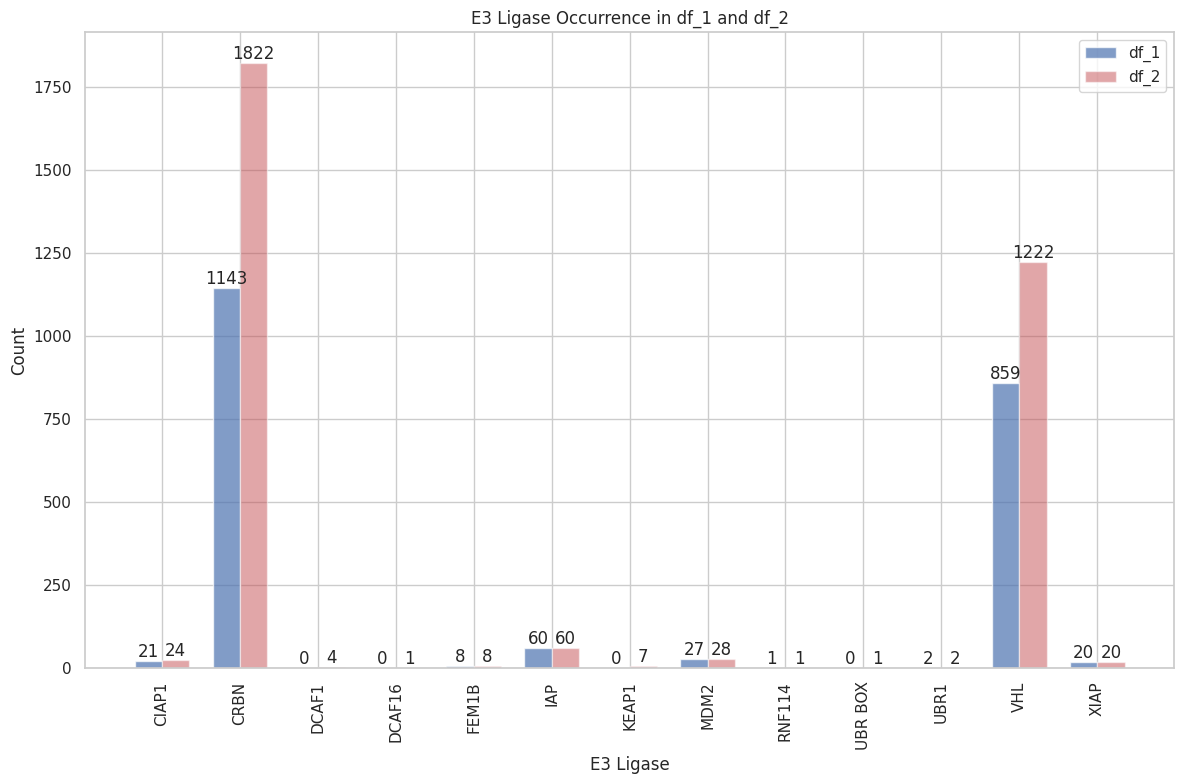

In [ ]:
df2=pd.read_csv('../data/PROTAC-Degradation-DB-2025.csv') # data curated from PROTAC 3.0
df1=pd.read_csv('../data/PROTAC-Degradation-DB.csv')
df1['E3 Ligase'] = df1['E3 Ligase'].str.upper()
df2['E3 Ligase'] = df2['E3 Ligase'].str.upper()
counts_df1 = df1['E3 Ligase'].value_counts().rename('df_1').reset_index()
counts_df2 = df2['E3 Ligase'].value_counts().rename('df_2').reset_index()

# Rename columns
counts_df1.columns = ['E3 Ligase', 'df_1']
counts_df2.columns = ['E3 Ligase', 'df_2']

# Merge the frequency counts from both datasets
merged_counts = pd.merge(counts_df1, counts_df2, on='E3 Ligase', how='outer').fillna(0)

# Set index for plotting
categories = merged_counts['E3 Ligase']
index = np.arange(len(categories))
bar_width = 0.35

# Draw the bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bar1 = ax.bar(index, merged_counts['df_1'], bar_width, label='df_1', color='b', alpha=0.7)
bar2 = ax.bar(index + bar_width, merged_counts['df_2'], bar_width, label='df_2', color='r', alpha=0.5)

# Add value labels on top of each bar
for i, count in enumerate(merged_counts['df_1']):
    ax.text(i, count, int(count), ha='center', va='bottom')
for i, count in enumerate(merged_counts['df_2']):
    ax.text(i + bar_width, count, int(count), ha='center', va='bottom')

# Add title and axis labels
ax.set_title('E3 Ligase Occurrence in df_1 and df_2')
ax.set_xlabel('E3 Ligase')
ax.set_ylabel('Count')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories, rotation=90)  # Adjust label rotation as needed
ax.legend()

plt.tight_layout()
plt.show()

In [38]:
cols_to_compare = ['Uniprot', 'E3 Ligase', 'Target (Parsed)', 'Target']

#find out the new uniprot, new cell line ,new target,new E3 ligase
diff_entries = {}
for col in cols_to_compare:
    
    diff_entries[col] = df_2[col][~df_2[col].isin(df_1[col])].unique()


for col, diff in diff_entries.items():
    print(f"In column '{col}', these values are in df_3.0 but not in df_2.0: {diff}")

In column 'Uniprot', these values are in df_3.0 but not in df_2.0: ['P43490' 'P56524' 'P36969' 'Q5S007' 'Q14145' 'Q93009' 'Q92793' 'Q09472'
 'P30530' 'Q13164' 'Q96RR4' nan 'P07437' 'Q13490' 'Q13489' 'P98170'
 'P15170' 'P35968' 'Q9BZ95' 'Q86WV6' 'P08238' 'P37840' 'Q15004' 'Q92918'
 'Q9BV86' 'P22736' 'P50395' 'P42229' 'P42226' 'P03436' 'P00918' 'P00338'
 'P07195' 'Q08881' 'P0DTD1' 'Q86X55' 'P08581' 'Q16342' 'Q9Y2I7' 'O75608'
 'Q8NB16' 'P52789' 'P18031' 'P17706' 'Q8TBX8' 'P51692' 'P29597' 'P23458'
 'O96028' 'Q96C86' 'P14625' 'P06493' 'P27361' 'Q9C5S2']
In column 'E3 Ligase', these values are in df_3.0 but not in df_2.0: ['Keap1' 'UBR box' 'DCAF1' 'DCAF16']
In column 'Target (Parsed)', these values are in df_3.0 but not in df_2.0: ['NAMPT' 'HDAC4' 'GPX4' 'LRRK2' 'G2019S LRRK2' 'KRAS G12D' 'Keap1' 'USP7'
 'CBP' 'p300' 'AXL' 'ERK5' 'CAMKK2' 'alpha-tubulin' 'beta-tubulin'
 'beta3-tubulin' 'FLT3' 'cIAP1' 'cIAP2' 'XIAP' 'GSPT1' 'KEAP1' 'Bcl-xL'
 'VEGFR-2' 'NSD3' 'CypA' 'STING' 'HSP90alpha' 'HSP